[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Anteemony/sktime-storesales-forecasting/blob/main/notebooks/Store_Sales_Forecasting_with_Sktime.ipynb)

# 🏪Store Sales - Time Series Forecasting *using Sktime*

**Project Description**

Using the Sktime framework for our time-series forecasting, how can we predict grocery sales? The aim is to predict the sales for thousands of product families sold at Favorita stores located in Eucador.

**Data**

The data is downloaded from the Kaggle Competition [Store Sales - Time Series Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data)

It includes the following datasets

* train.csv
* test.csv
* sample_submission.csv
* stores.csv
* oil.csv
* holiday_events.csv

A codeblock has been provided to download this data directly from kaggle programmatically.

**Evaluation**

The evaluation metric is the Root Mean Squared Log Error or RMSLE between the actual and predicted sales.

**Features**

Kaggle explains the features of all the provided datasets in the [competition data tab](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data)



## Download Kaggle Data

Uncomment the below codeblock to download the datasets from kaggle programmatically. You would need to get your configure input your Kaggle API key and username. Find your API Key from your Kaggle settings [here](https://www.kaggle.com/settings).

In [4]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

!kaggle competitions download -c store-sales-time-series-forecasting

! unzip "store-sales-time-series-forecasting.zip" -d data

100% 21.4M/21.4M [00:01<00:00, 32.3MB/s]
100% 21.4M/21.4M [00:01<00:00, 20.2MB/s]
Archive:  store-sales-time-series-forecasting.zip
  inflating: data/holidays_events.csv  
  inflating: data/oil.csv            
  inflating: data/sample_submission.csv  
  inflating: data/stores.csv         
  inflating: data/test.csv           
  inflating: data/train.csv          
  inflating: data/transactions.csv   


# EDA

In [5]:
# ensure required libraries are installed
!pip -q install sktime pmdarima seaborn

# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# EDA / modelling
import sktime

# ignore warnings for clean cell output
from warnings import simplefilter
simplefilter('ignore')

Load the datasets

In [6]:
dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',

    'city': 'category',
    'state': 'category',
    'type': 'category',
    'cluster': 'category',

    'dcoilwtico': 'float32',

    'type': 'category',
    'locale': 'category',
    'locale_name': 'category',
    'description': 'string',
    'transferred': 'bool',

    'transactions': 'int64'
}
store_sales = pd.read_csv(
    './data/train.csv',
    dtype=dtype,
    parse_dates=['date']
)

store_metadata = pd.read_csv(
    './data/stores.csv',
    dtype=dtype,
)

daily_oil_price = pd.read_csv(
    './data/oil.csv',
    dtype=dtype,
    parse_dates=['date']
)

holidays_events = pd.read_csv(
    './data/holidays_events.csv',
    dtype=dtype,
    parse_dates=['date']
)

transactions = pd.read_csv(
    './data/transactions.csv',
    dtype=dtype,
    parse_dates=['date']
)

In [7]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    category      
 3   family       category      
 4   sales        float32       
 5   onpromotion  uint64        
dtypes: category(2), datetime64[ns](1), float32(1), int64(1), uint64(1)
memory usage: 85.9 MB


In [8]:
store_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   store_nbr  54 non-null     category
 1   city       54 non-null     category
 2   state      54 non-null     category
 3   type       54 non-null     category
 4   cluster    54 non-null     category
dtypes: category(5)
memory usage: 5.1 KB


In [9]:
daily_oil_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 14.4 KB


In [10]:
holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    category      
 2   locale       350 non-null    category      
 3   locale_name  350 non-null    category      
 4   description  350 non-null    string        
 5   transferred  350 non-null    bool          
dtypes: bool(1), category(3), datetime64[ns](1), string(1)
memory usage: 8.0 KB


In [11]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  category      
 2   transactions  83488 non-null  int64         
dtypes: category(1), datetime64[ns](1), int64(1)
memory usage: 1.4 MB


## Data Visualization

# TREND

Let's Examine the Trend in Favorita store sales by answering the following questions.

1. Average sales Favorita makes each day
2. Average sales each product family brings to favorita each day

In [100]:
# Function for moving average plot
def plot_moving_average(df, window, ax, plot_df=None, remove_legend=False):
    moving_average = df.rolling(
        window=window,
        center=True,
        min_periods=window//2
    ).mean()

    if plot_df is None:
        plot_df = df

    plot_df.plot(style=".", color="0.5", ax=ax)
    moving_average.plot(
        ax=ax, linewidth=3, title=f"Store Sales- {window}-Day Moving Average", legend=False
    )

    if remove_legend:
      try:
        ax.get_legend().remove()
      except:
        pass

In [109]:
# 1. Average sales Favorita makes each day
daily_average_sales = store_sales.groupby('date').mean()['sales']
daily_average_sales

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911163
2013-01-05    267.873260
                 ...    
2017-08-11    463.733856
2017-08-12    444.798309
2017-08-13    485.768616
2017-08-14    427.004730
2017-08-15    427.980896
Freq: D, Name: sales, Length: 1684, dtype: float32

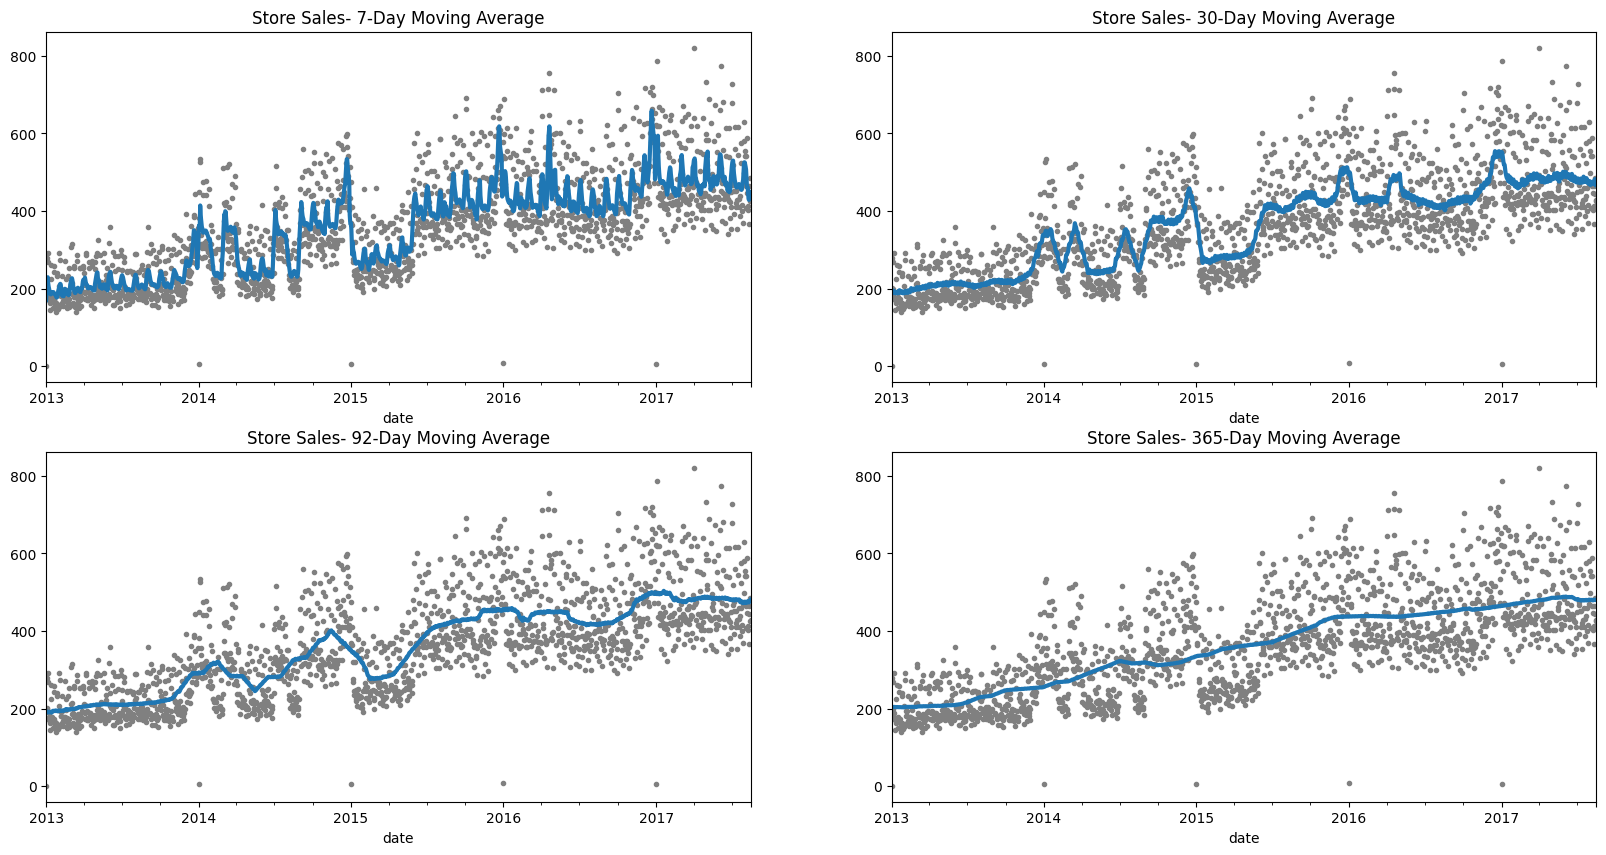

In [102]:

# Let's see the trend
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2,
                                             ncols=2,
                                             figsize=(20,10))

windows = [7, 30, 92, 365]
axes =[ax1, ax2, ax3, ax4]

for window, ax in zip(windows, axes):
    plot_moving_average(df=daily_average_sales, window=window, ax=ax)

##2. Average sales each product family brings to Favorita each day


Favorita stores has 33 product families.
* What's the sales trend for each product family?

In [103]:
# Group by 'date' and 'family', calculate mean sales
daily_avg_family_sales = store_sales.groupby(['date', 'family'])['sales'].mean().reset_index()

# Pivot the data for easier plotting (date as index, family as columns)
pivot_df = daily_avg_family_sales.pivot(index='date', columns='family', values='sales')
pivot_df.head()

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.000000,0.0,0.037037,15.000000,0.0,3.344241,0.0,3.444444,2.648148,1.316481,...,0.0,2.051870,0.462963,0.0,0.0,0.789574,0.700870,0.0,0.0,0.000000
2013-01-02,4.722222,0.0,3.833333,1335.036987,0.0,486.042938,0.0,1382.018555,432.981476,291.750000,...,0.0,386.508606,318.592590,0.0,0.0,258.812683,98.853935,0.0,0.0,28.273148
2013-01-03,2.981482,0.0,2.314815,964.907410,0.0,341.786682,0.0,1035.055542,333.351837,206.897324,...,0.0,307.359222,232.740738,0.0,0.0,197.673965,66.507187,0.0,0.0,20.265018
2013-01-04,3.129630,0.0,2.462963,1003.092590,0.0,309.666077,0.0,964.148132,336.074066,187.837204,...,0.0,400.480804,209.314819,0.0,0.0,199.491013,82.832703,0.0,0.0,23.946684
2013-01-05,6.333333,0.0,3.537037,1441.074097,0.0,414.217804,0.0,1298.666626,427.444458,254.350845,...,0.0,386.649841,311.462952,0.0,0.0,249.537201,107.964317,0.0,0.0,23.067350


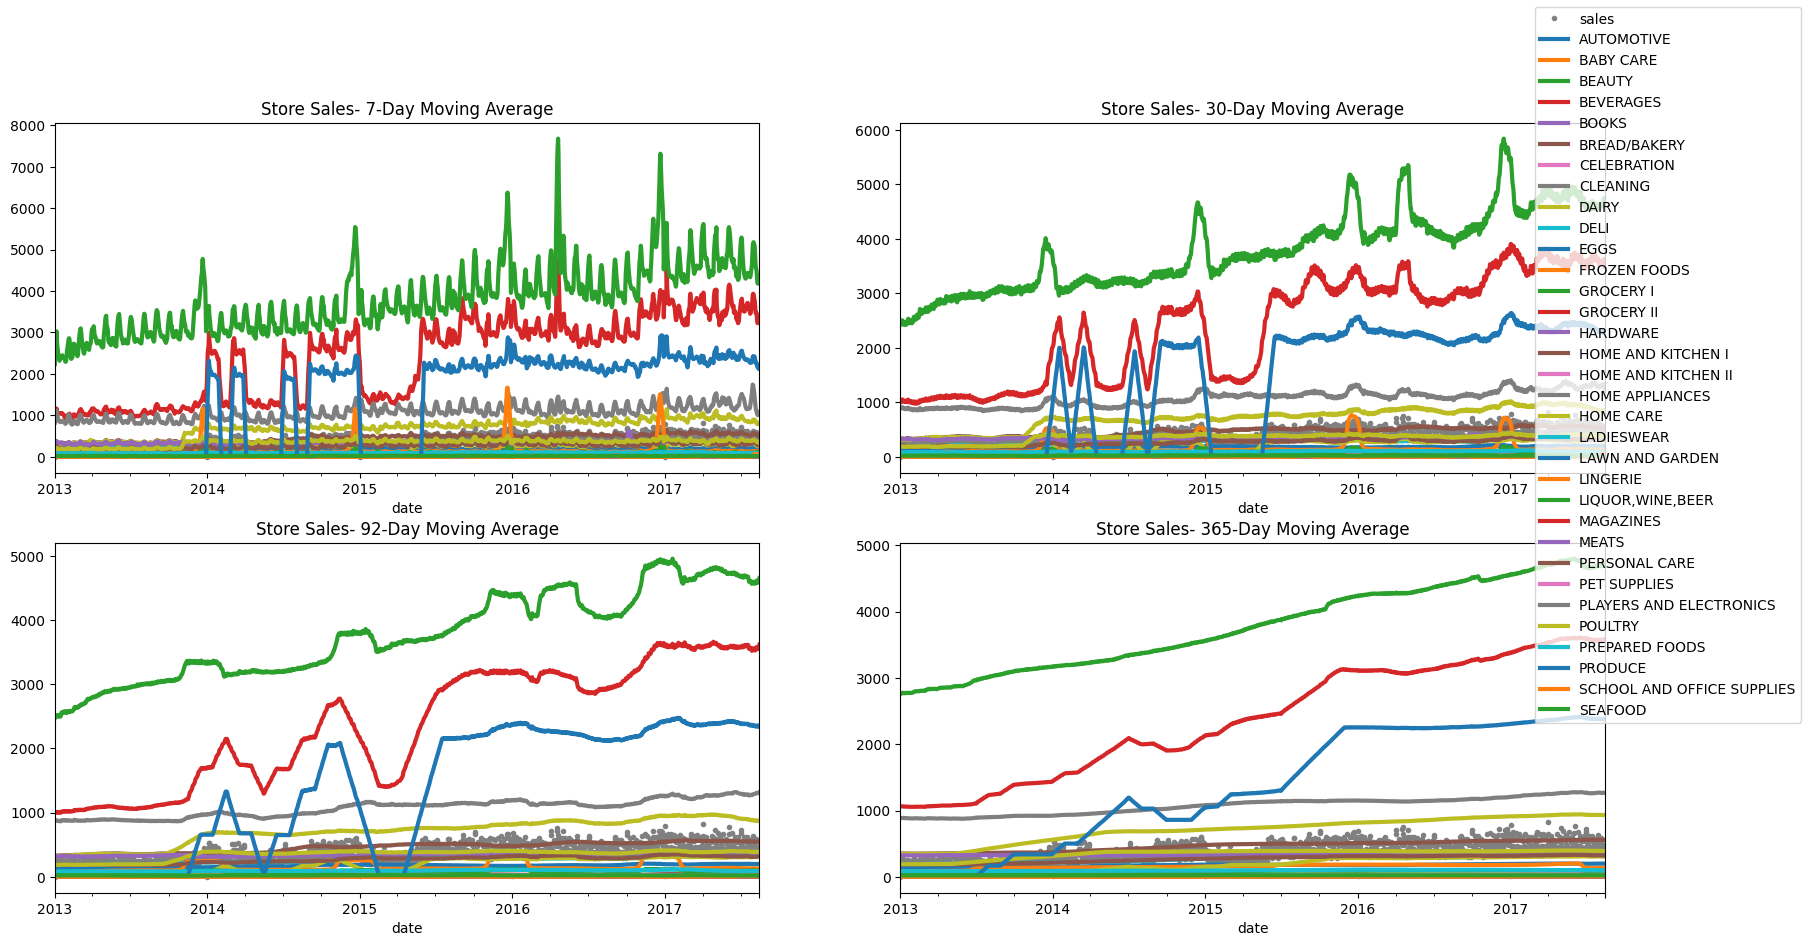

In [129]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2,
                                             ncols=2,
                                             figsize=(20,10))

windows = [7, 30, 92, 365]
axes =[ax1, ax2, ax3, ax4]

for window, ax in zip(windows, axes):
    plot_moving_average(
        df=pivot_df,
        plot_df=daily_average_sales,
        window=window, ax=ax)

# Use a single Legend
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

### Which product families are making the most sales?

Let's look at the top families that bring in the most sales

In [131]:
avg_sales = store_sales.groupby('family')['sales'].mean().sort_values(ascending=False)
top_families = avg_sales.head(5).index

pivot_df_filtered = pivot_df[top_families]
pivot_df_filtered

# Calculate daily average sales for the top families
daily_avg_sales_top_families = pivot_df_filtered.mean(axis=1)

Average sales for top product families

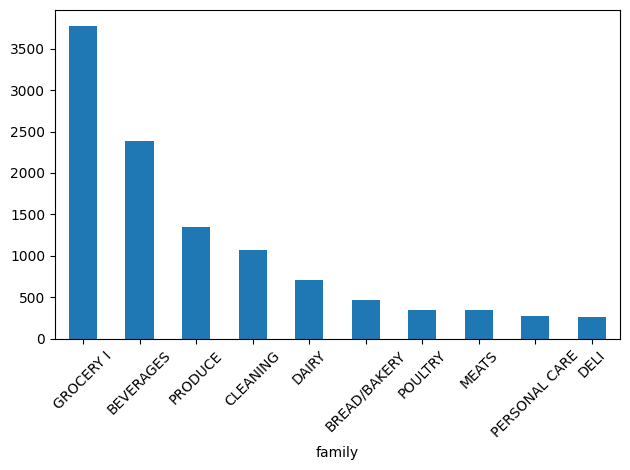

In [130]:
# Group by product 'family' and calculate the average sales
avg_sales = store_sales.groupby('family')['sales'].mean().sort_values(ascending=False)

# Take the top 20 product families
top_families = avg_sales.head(10)

top_families.plot(kind="bar")


# Rotate x-axis labels for better readability if there are many families
plt.xticks(rotation=45)
# Display the plot
plt.tight_layout()  # Ensures all labels fit within the figure area
plt.show()

View the Top families sales trend

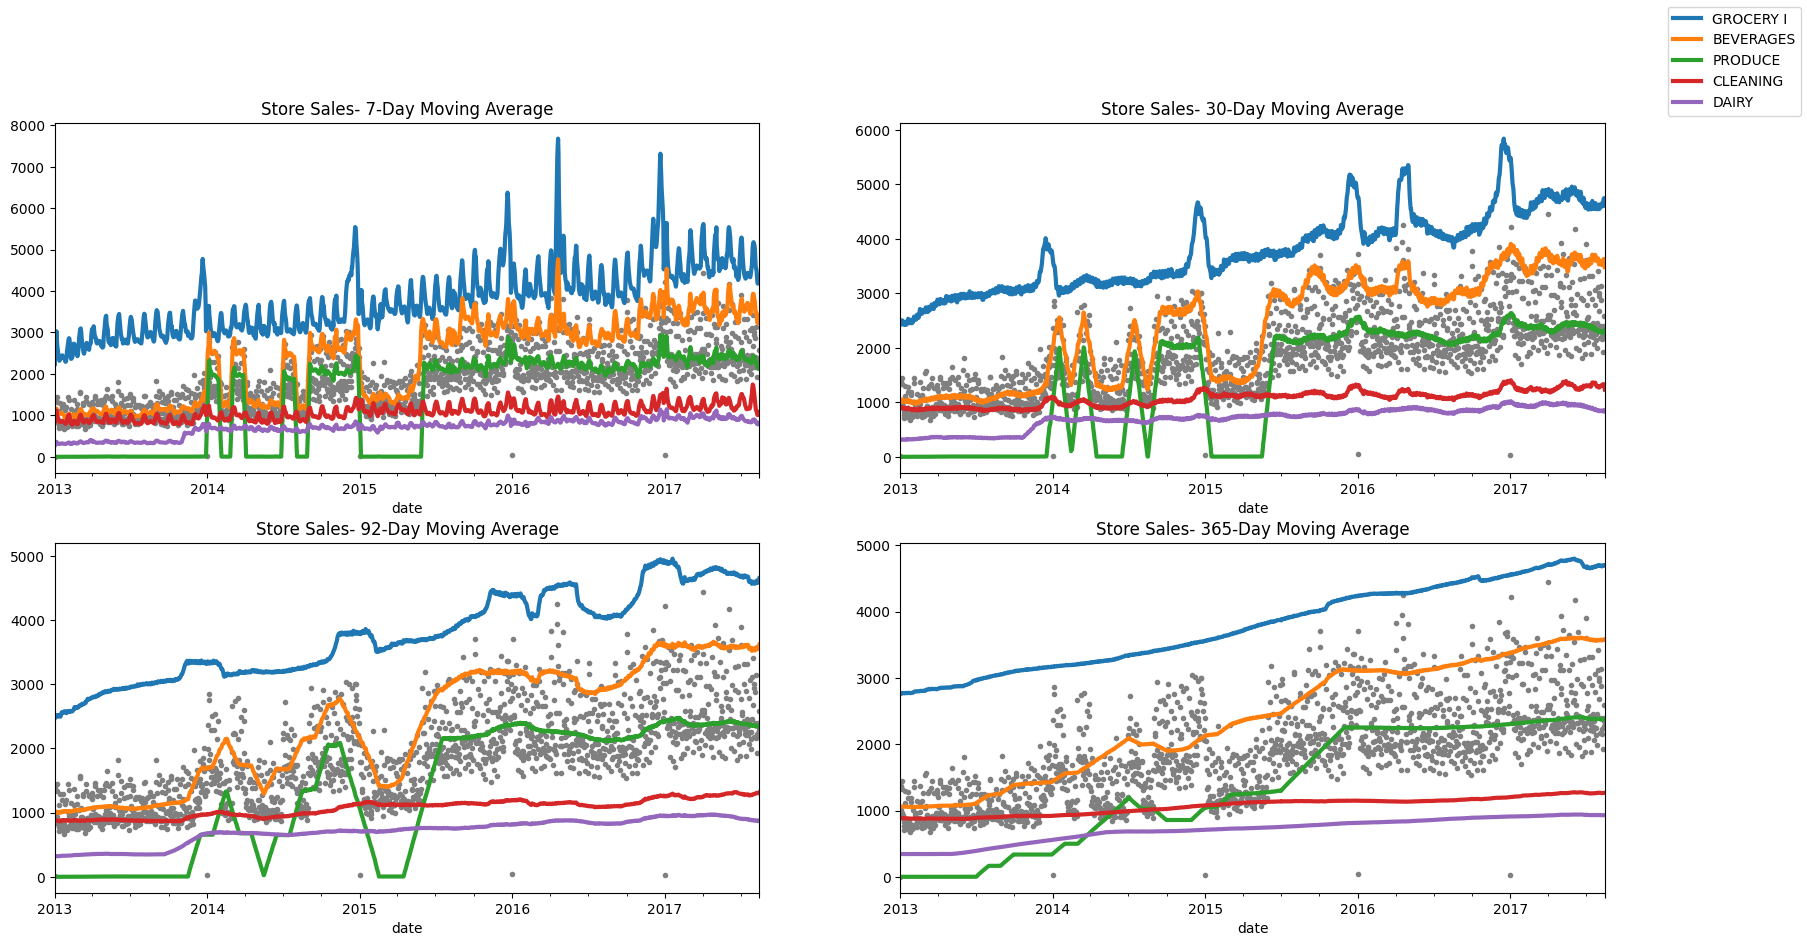

In [132]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2,
                                             ncols=2,
                                             figsize=(20,10))

windows = [7, 30, 92, 365]
axes =[ax1, ax2, ax3, ax4]

for window, ax in zip(windows, axes):
    plot_moving_average(
        df=pivot_df[top_families],
        plot_df=daily_avg_sales_top_families,
        window=window, ax=ax)

# Use a single Legend
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');